In [1]:
import sklearn
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('bright')

In [2]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
        return mz_table



In [3]:
df=pd.read_csv('train.csv',index_col='Id')

**Identifying features with substantial amounts of missing vales**

In [4]:
mzvt=missing_zero_values_table(df)
mzvt

Your selected dataframe has 80 columns and 1460 Rows.
There are 19 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
PoolQC,0,1453,99.5,1453,99.5,object
MiscFeature,0,1406,96.3,1406,96.3,object
Alley,0,1369,93.8,1369,93.8,object
Fence,0,1179,80.8,1179,80.8,object
FireplaceQu,0,690,47.3,690,47.3,object
LotFrontage,0,259,17.7,259,17.7,float64
GarageType,0,81,5.5,81,5.5,object
GarageYrBlt,0,81,5.5,81,5.5,float64
GarageFinish,0,81,5.5,81,5.5,object
GarageQual,0,81,5.5,81,5.5,object


The table above shows features: PoolQC, MiscFeature, Alley, Fence, FireplaceQu and LotFrontage having significantly more missing values than the majority of the features. I am going to drop these features.

In [5]:
#Creating a slice of the % of total value column
drop_mzvt=mzvt['% of Total Values'] 
#Creating a list of index names which have more than 10% missing values
todrop=drop_mzvt[drop_mzvt>10].index
#Dropping the list of index names from the df
df.drop(todrop,axis=1,inplace=True)

## **Initial data exploration**

In [6]:
#The number of features we have according to their data types
df.dtypes.value_counts()

object     38
int64      34
float64     2
dtype: int64

In [7]:
#A closer look at the corresponding data type
df.info(null_counts=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 74 columns):
 #   Column         Dtype  
---  ------         -----  
 0   MSSubClass     int64  
 1   MSZoning       object 
 2   LotArea        int64  
 3   Street         object 
 4   LotShape       object 
 5   LandContour    object 
 6   Utilities      object 
 7   LotConfig      object 
 8   LandSlope      object 
 9   Neighborhood   object 
 10  Condition1     object 
 11  Condition2     object 
 12  BldgType       object 
 13  HouseStyle     object 
 14  OverallQual    int64  
 15  OverallCond    int64  
 16  YearBuilt      int64  
 17  YearRemodAdd   int64  
 18  RoofStyle      object 
 19  RoofMatl       object 
 20  Exterior1st    object 
 21  Exterior2nd    object 
 22  MasVnrType     object 
 23  MasVnrArea     float64
 24  ExterQual      object 
 25  ExterCond      object 
 26  Foundation     object 
 27  BsmtQual       object 
 28  BsmtCond       object 
 29  BsmtExposure   objec

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

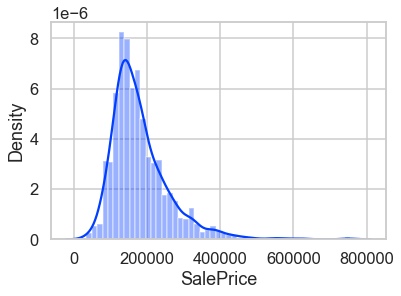

In [8]:
sns.distplot(df['SalePrice'])

In [9]:
df['SalePrice'].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

#### **Correlation between the features**

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pipeline for numerical datatypes
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
# Pipeline for categorical datatypes
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# List of numerical features
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
# List of catergorical features
categorical_features = df.select_dtypes(include=['object']).columns
# Column transformer applies the correct pipeline to the correponding data type columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Transforming data using pipeline
trpipe=Pipeline(steps=[('preprocessor',preprocessor)])
trdata=trpipe.fit_transform(df)
